# Standard Sparse AutoEncoder

In [1]:
from nlp_features.sae.standard_sae   import StandardTrainer, AutoEncoder
activation_dim, dict_size = 512, 1000
device='cuda:0'
trainer = StandardTrainer(
    activation_dim=512,
    dict_size=64*512,
    lr=1e-4,
    l1_penalty=5e-2,
    warmup_steps=100, # lr warmup period at start of training and after each resample
    device=device,
    resample_steps=100, # how often to resample neurons,
    steps=2000,
)

In [2]:
import os
import torch
# check save
path = 'outputs'
os.makedirs(path, exist_ok=True)

ae = trainer.ae
torch.save(ae.state_dict(), "outputs/params.pth")

# check load
path =  "outputs/params.pth"
loaded_ae = AutoEncoder.from_pretrained(path)
loaded_ae

AutoEncoder(
  (encoder): Linear(in_features=512, out_features=32768, bias=True)
  (decoder): Linear(in_features=32768, out_features=512, bias=False)
)

In [3]:
# encode and decode
import torch
activations = torch.randn(4, activation_dim, device=device)
features = ae.encode(activations)
reconstructed_activations = ae.decode(features)

reconstructed_activations, features = ae(activations, output_features=True)
reconstructed_activations.shape, features.shape

(torch.Size([4, 512]), torch.Size([4, 32768]))

In [4]:
# train

import torch
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

infos = {}
log_step = 5
total_steps = 2000

pbar = tqdm(total=total_steps)
for step in range(total_steps):
    pbar.update(1)
    act = torch.randn(32, 512).to(device)
    trainer.update(step, act)
    if step % log_step == 0:
        with torch.no_grad():
            infos[step] = trainer.loss(act, logging=True)[3]


100%|█████████▉| 1992/2000 [00:15<00:00, 131.72it/s]

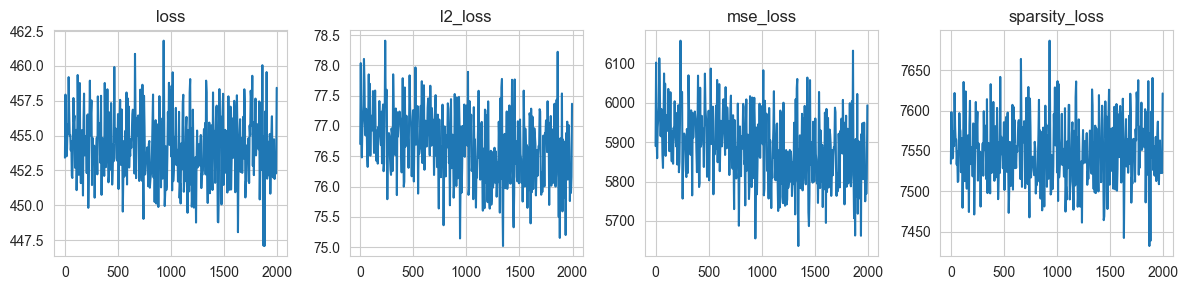

In [5]:

sns.set_style("whitegrid")
def visualize_infos(infos, figsize=(10,2.5)):
    steps = sorted(list(infos.keys()))
    names = list(infos[steps[0]].keys())
    fig, axes = plt.subplots(1, len(names), figsize=figsize)
    for i in range(len(names)):
        name = names[i]
        sns.lineplot(x=steps, y=[infos[step][name] for step in steps], ax=axes[i])
        axes[i].set_title(name)
        # if i < 2:
        #     axes[i].set_ylim(0,50)

    plt.tight_layout()
    return fig, axes
visualize_infos(infos, figsize=(12,3))

os.makedirs("assets", exist_ok=True)
plt.savefig("assets/loss.png")